In [ ]:
import numpy as np
import pandas as pd 
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
color_palette = sns.color_palette()
%matplotlib inline

##### Neste ponto as tabelas já foram inspecionadas no Excel e foi notado que em geral os dados estão limpos e consistentes, com alguns NULLs. A grande excessão no entanto são as colunas de LATITUDE e LONGITUDE da tabela 'ocorrencia.csv' que são uma completa bangunça de NULLS e formatações aleatórias, incluindo visíveis erros (ocorrências em ountros continentes por exemplo). Para solucionar isto optou-se por utilizar o GeoPy, que possibilitou adquirir as coordenadas das ocorrências a partir do nome da cidade e substituir os valores claramente errados. Em seguir prossigo para deixar a formatação consistente entre todos as coordenadas.

## Input dos dados e breve exploração

In [ ]:
df_ocorr = pd.read_csv('ocorrencia.csv', sep=';', encoding = "ISO-8859-1")

In [4]:
df_ocorr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5459 entries, 0 to 5458
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   codigo_ocorrencia               5459 non-null   int64 
 1   codigo_ocorrencia1              5459 non-null   int64 
 2   codigo_ocorrencia2              5459 non-null   int64 
 3   codigo_ocorrencia3              5459 non-null   int64 
 4   codigo_ocorrencia4              5459 non-null   int64 
 5   ocorrencia_classificacao        5459 non-null   object
 6   ocorrencia_latitude             4800 non-null   object
 7   ocorrencia_longitude            4800 non-null   object
 8   ocorrencia_cidade               5459 non-null   object
 9   ocorrencia_uf                   5459 non-null   object
 10  ocorrencia_pais                 5459 non-null   object
 11  ocorrencia_aerodromo            5459 non-null   object
 12  ocorrencia_dia                  5459 non-null   

In [8]:
df_prep = df_ocorr.copy()

In [9]:
df_prep.loc[df_ocorr['ocorrencia_cidade'].isnull()]

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista


In [10]:
df_prep['ocorrencia_latitude'].isnull().value_counts()

False    4800
True      659
Name: ocorrencia_latitude, dtype: int64

In [11]:
df_prep['ocorrencia_longitude'].isnull().value_counts()

False    4800
True      659
Name: ocorrencia_longitude, dtype: int64

## Usando GeoPy para popular as coordenadas ausentes e erradas

In [12]:
### Importando o GeoPy para obter as coordenadas a partir do nome das cidades

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="nilo")

In [13]:
test = geolocator.geocode("OURILÂNDIA DO NORTE")

In [14]:
test.latitude

-6.748975

In [16]:
### Vamos gravar as coordenadas de todas as cidades para uso posterior
cities = df_prep['ocorrencia_cidade'].unique()
len(cities)

In [17]:
city_coords = []
for i in range(len(cities)):
     location = geolocator.geocode(cities[i], country_codes='br')
     city_coords.append((cities[i], location.latitude, location.longitude))

In [18]:
df_cities = pd.DataFrame(city_coords)

In [19]:
df_cities = df_cities.set_index(0)

In [20]:
df_cities.set_axis(['latitude', 'longitude'], axis='columns', inplace=True)

In [21]:
df_cities.index.name = 'cidade'

In [22]:
df_cities.to_csv('cities_coords.csv')

In [15]:
df_cities = pd.read_csv('cities_coords.csv')

In [16]:
df_cities = df_cities.set_index('cidade')

In [17]:
### Substituindo os NULL pelas coordenadas das cidades
### Deve-se usar tolist() para evitar uma series com indices duplicados, após a aplicação do .loc

df_prep.loc[df_prep['ocorrencia_latitude'].isnull(), 'ocorrencia_latitude'] = \
df_cities.loc[df_prep.loc[df_prep['ocorrencia_latitude'].isnull(), 'ocorrencia_cidade'], 'latitude'].tolist()

In [18]:
df_prep.loc[df_prep['ocorrencia_longitude'].isnull(), 'ocorrencia_longitude'] = \
df_cities.loc[df_prep.loc[df_prep['ocorrencia_longitude'].isnull(), 'ocorrencia_cidade'], 'longitude'].tolist()

## Limpeza e formatação das coordenadas

In [19]:
### Não há o símbolo '°' nas longitudes
df_prep.loc[df_prep['ocorrencia_longitude'].str.contains('°', na=False)]

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista


In [20]:
### Mas há um nas latitudes
df_prep.loc[df_prep['ocorrencia_latitude'].str.contains('°', na=False)]

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
2282,78768,78768,78768,78768,78768,ACIDENTE,-23.005278°,-46.636944,BRAGANÇA PAULISTA,SP,...,27/07/2019,17:15:00,SIM,FINALIZADA,A-115/CENIPA/2019,SIM,2021-07-08,1,1,SIM


In [21]:
### Corrigindo

df_prep.loc[df_prep['ocorrencia_latitude'].str.contains('°', na=False), 'ocorrencia_latitude'] = \
df_prep.loc[df_prep['ocorrencia_latitude'].str.contains('°', na=False), 'ocorrencia_latitude'].str.replace('°','0')

In [22]:
### Ainda restam muitas formatações estranhas

df_prep[['ocorrencia_latitude', 'ocorrencia_longitude']].value_counts()

ocorrencia_latitude  ocorrencia_longitude
***                  ***                     724
-23.00694444444      -47.13444444444         105
-23.43555555555      -46.47305555555          72
-22.911013699999998  -43.2093727              62
-23.50666666666      -46.63388888888          53
                                            ... 
-23.56666666666      -46.43333333333           1
-23.56638            -46.06944                 1
-23.5658333333       -46.8538888889            1
-23.5655             -46.0694                  1
-32.033425199999996  -52.0991297               1
Length: 2900, dtype: int64

In [23]:
df_prep.loc[df_prep['ocorrencia_latitude'].str.count('\.') > 1, 'ocorrencia_latitude'].value_counts()

-198.519.444.44    14
-199.091.666.66     9
-232.288.888.88     7
-211.363.888.88     4
-167.061.111.11     3
                   ..
-157.152.777.77     1
-222.427.777.77     1
-78.213.888.889     1
-160.347.222.22     1
-174.002.777.77     1
Name: ocorrencia_latitude, Length: 90, dtype: int64

In [24]:
df_prep.loc[df_prep['ocorrencia_longitude'].str.count('\.') > 1, 'ocorrencia_longitude'].value_counts()

-439.505.555.55    14
-432.505.555.55    11
-439.891.666.66     9
-458.711.111.11     7
-477.766.666.66     4
                   ..
-466.341.666.66     1
-525.816.666.66     1
-459.763.888.88     1
-433.738.888.88     1
-479.013.888.88     1
Name: ocorrencia_longitude, Length: 87, dtype: int64

In [25]:
df_prep.loc[df_prep['ocorrencia_latitude'] == '***']

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
60,81633,81633,81633,81633,81633,ACIDENTE,***,***,BIRITIBA-MIRIM,SP,...,11/07/2020,20:15:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
64,81621,81621,81621,81621,81621,INCIDENTE GRAVE,***,***,SÃO DESIDÉRIO,BA,...,16/05/2023,18:00:00,SIM,ATIVA,IG-083/CENIPA/2023,NÃO,NaN,0,1,SIM
71,81570,81570,81570,81570,81570,INCIDENTE,***,***,NAVEGANTES,SC,...,15/05/2023,12:50:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
78,81559,81559,81559,81559,81559,INCIDENTE,***,***,BELÉM,PA,...,11/05/2023,12:40:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
79,81558,81558,81558,81558,81558,INCIDENTE,***,***,RIO DE JANEIRO,RJ,...,11/05/2023,19:36:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5425,46874,46874,46874,46874,46874,INCIDENTE,***,***,MARABÁ PAULISTA,SP,...,25/01/2013,11:15:00,***,FINALIZADA,***,NÃO,NaN,0,1,SIM
5432,46866,46866,46866,46866,46866,INCIDENTE,***,***,RIO DE JANEIRO,RJ,...,19/01/2013,19:00:00,***,FINALIZADA,***,NÃO,NaN,0,1,NÃO
5435,46863,46863,46863,46863,46863,INCIDENTE GRAVE,***,***,BOITUVA,SP,...,11/01/2013,21:50:00,***,FINALIZADA,IG-005/CENIPA/2013,NÃO,NaN,0,1,NÃO
5436,46862,46862,46862,46862,46862,ACIDENTE,***,***,BOITUVA,SP,...,25/01/2013,17:40:00,***,FINALIZADA,A-018/CENIPA/2013,SIM,2019-09-03,1,1,NÃO


In [26]:
df_prep.loc[df_prep['ocorrencia_longitude'] == '***']

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
60,81633,81633,81633,81633,81633,ACIDENTE,***,***,BIRITIBA-MIRIM,SP,...,11/07/2020,20:15:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
64,81621,81621,81621,81621,81621,INCIDENTE GRAVE,***,***,SÃO DESIDÉRIO,BA,...,16/05/2023,18:00:00,SIM,ATIVA,IG-083/CENIPA/2023,NÃO,NaN,0,1,SIM
71,81570,81570,81570,81570,81570,INCIDENTE,***,***,NAVEGANTES,SC,...,15/05/2023,12:50:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
78,81559,81559,81559,81559,81559,INCIDENTE,***,***,BELÉM,PA,...,11/05/2023,12:40:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
79,81558,81558,81558,81558,81558,INCIDENTE,***,***,RIO DE JANEIRO,RJ,...,11/05/2023,19:36:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5425,46874,46874,46874,46874,46874,INCIDENTE,***,***,MARABÁ PAULISTA,SP,...,25/01/2013,11:15:00,***,FINALIZADA,***,NÃO,NaN,0,1,SIM
5432,46866,46866,46866,46866,46866,INCIDENTE,***,***,RIO DE JANEIRO,RJ,...,19/01/2013,19:00:00,***,FINALIZADA,***,NÃO,NaN,0,1,NÃO
5435,46863,46863,46863,46863,46863,INCIDENTE GRAVE,***,***,BOITUVA,SP,...,11/01/2013,21:50:00,***,FINALIZADA,IG-005/CENIPA/2013,NÃO,NaN,0,1,NÃO
5436,46862,46862,46862,46862,46862,ACIDENTE,***,***,BOITUVA,SP,...,25/01/2013,17:40:00,***,FINALIZADA,A-018/CENIPA/2013,SIM,2019-09-03,1,1,NÃO


In [27]:
### Substituindo pelas coordenadas das cidades

df_prep.loc[df_prep['ocorrencia_latitude'].str.count('\.') > 1, 'ocorrencia_latitude'] = \
df_cities.loc[df_prep.loc[df_prep['ocorrencia_latitude'].str.count('\.') > 1, 'ocorrencia_cidade'], 'latitude'].tolist()

In [28]:
df_prep.loc[df_prep['ocorrencia_longitude'].str.count('\.') > 1, 'ocorrencia_longitude'] = \
df_cities.loc[df_prep.loc[df_prep['ocorrencia_longitude'].str.count('\.') > 1, 'ocorrencia_cidade'], 'longitude'].tolist()

In [29]:
df_prep.loc[df_prep['ocorrencia_latitude'] == '***', 'ocorrencia_latitude'] = \
df_cities.loc[df_prep.loc[df_prep['ocorrencia_latitude'] == '***', 'ocorrencia_cidade'], 'latitude'].tolist()

In [30]:
df_prep.loc[df_prep['ocorrencia_longitude'] == '***', 'ocorrencia_longitude'] = \
df_cities.loc[df_prep.loc[df_prep['ocorrencia_longitude'] == '***', 'ocorrencia_cidade'], 'longitude'].tolist()

In [31]:
### Vamos tentar converter as colunas para o tipo 'numeric' para ver se há mais valores estranhos

df_prep['ocorrencia_latitude'] = pd.to_numeric(df_prep['ocorrencia_latitude'])

ValueError: Unable to parse string "-14,92416" at position 588

In [32]:
df_prep['ocorrencia_longitude'] = pd.to_numeric(df_prep['ocorrencia_longitude'])

ValueError: Unable to parse string "-41,95666" at position 588

In [33]:
# Muitos erros!

In [35]:
### Muitas coordenadas possuem vírgula em vez de ponto

df_prep.loc[df_prep['ocorrencia_latitude'].str.contains(',', na=False)]

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
588,80885,80885,80885,80885,80885,ACIDENTE,"-14,92416","-41,95666",CONDEÚBA,BA,...,27/07/2022,13:40:00,SIM,ATIVA,A-086/CENIPA/2022,NÃO,NaN,0,1,SIM
601,80871,80871,80871,80871,80871,ACIDENTE,"-22,95941","-52,96531",LOANDA,PR,...,19/07/2022,17:00:00,SIM,ATIVA,A-084/CENIPA/2022,NÃO,NaN,0,1,NÃO
629,80836,80836,80836,80836,80836,ACIDENTE,"-12,29333","-40,57166",RUY BARBOSA,BA,...,04/07/2022,12:10:00,SIM,FINALIZADA,A-081/CENIPA/2022,SIM,2023-04-17,0,1,NÃO
631,80834,80834,80834,80834,80834,INCIDENTE,"-39,03333","-14,85100",ILHÉUS,BA,...,04/07/2022,21:34:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
735,80711,80711,80711,80711,80711,INCIDENTE,"-23,44277373","-46,47348485",GUARULHOS,SP,...,01/05/2022,12:32:00,SIM,FINALIZADA,***,NÃO,NaN,0,2,NÃO
827,80597,80597,80597,80597,80597,ACIDENTE,"-22,89815","-46,55613",BRAGANÇA PAULISTA,SP,...,21/03/2022,14:35:00,SIM,ATIVA,A-036/CENIPA/2022,NÃO,NaN,0,1,NÃO
835,80589,80589,80589,80589,80589,ACIDENTE,"-13,48805","-38,80138",NÃO IDENTIFICADA,BA,...,16/03/2022,10:25:00,SIM,ATIVA,A-033/CENIPA/2022,NÃO,NaN,0,1,NÃO
914,80497,80497,80497,80497,80497,INCIDENTE GRAVE,"-12,12500","-45,77111",LUÍS EDUARDO MAGALHÃES,BA,...,21/01/2022,21:25:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
1044,80351,80351,80351,80351,80351,ACIDENTE,"-12,10000","-45,89500",LUÍS EDUARDO MAGALHÃES,BA,...,29/10/2021,19:35:00,SIM,FINALIZADA,A-119/CENIPA/2021,SIM,2023-05-31,0,1,SIM
1231,80132,80132,80132,80132,80132,INCIDENTE GRAVE,"-15,8711","-47,9186",BRASÍLIA,DF,...,17/06/2021,15:30:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO


In [36]:
df_prep.loc[df_prep['ocorrencia_longitude'].str.contains(',', na=False)]

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
588,80885,80885,80885,80885,80885,ACIDENTE,"-14,92416","-41,95666",CONDEÚBA,BA,...,27/07/2022,13:40:00,SIM,ATIVA,A-086/CENIPA/2022,NÃO,NaN,0,1,SIM
601,80871,80871,80871,80871,80871,ACIDENTE,"-22,95941","-52,96531",LOANDA,PR,...,19/07/2022,17:00:00,SIM,ATIVA,A-084/CENIPA/2022,NÃO,NaN,0,1,NÃO
629,80836,80836,80836,80836,80836,ACIDENTE,"-12,29333","-40,57166",RUY BARBOSA,BA,...,04/07/2022,12:10:00,SIM,FINALIZADA,A-081/CENIPA/2022,SIM,2023-04-17,0,1,NÃO
631,80834,80834,80834,80834,80834,INCIDENTE,"-39,03333","-14,85100",ILHÉUS,BA,...,04/07/2022,21:34:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
735,80711,80711,80711,80711,80711,INCIDENTE,"-23,44277373","-46,47348485",GUARULHOS,SP,...,01/05/2022,12:32:00,SIM,FINALIZADA,***,NÃO,NaN,0,2,NÃO
827,80597,80597,80597,80597,80597,ACIDENTE,"-22,89815","-46,55613",BRAGANÇA PAULISTA,SP,...,21/03/2022,14:35:00,SIM,ATIVA,A-036/CENIPA/2022,NÃO,NaN,0,1,NÃO
835,80589,80589,80589,80589,80589,ACIDENTE,"-13,48805","-38,80138",NÃO IDENTIFICADA,BA,...,16/03/2022,10:25:00,SIM,ATIVA,A-033/CENIPA/2022,NÃO,NaN,0,1,NÃO
914,80497,80497,80497,80497,80497,INCIDENTE GRAVE,"-12,12500","-45,77111",LUÍS EDUARDO MAGALHÃES,BA,...,21/01/2022,21:25:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
1044,80351,80351,80351,80351,80351,ACIDENTE,"-12,10000","-45,89500",LUÍS EDUARDO MAGALHÃES,BA,...,29/10/2021,19:35:00,SIM,FINALIZADA,A-119/CENIPA/2021,SIM,2023-05-31,0,1,SIM
1231,80132,80132,80132,80132,80132,INCIDENTE GRAVE,"-15,8711","-47,9186",BRASÍLIA,DF,...,17/06/2021,15:30:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO


In [37]:
df_prep.loc[df_prep['ocorrencia_latitude'].str.contains(',', na=False), 'ocorrencia_latitude'] = \
df_prep.loc[df_prep['ocorrencia_latitude'].str.contains(',', na=False), 'ocorrencia_latitude'].str.replace(',','.')

In [38]:
df_prep.loc[df_prep['ocorrencia_longitude'].str.contains(',', na=False), 'ocorrencia_longitude'] = \
df_prep.loc[df_prep['ocorrencia_longitude'].str.contains(',', na=False), 'ocorrencia_longitude'].str.replace(',','.')

In [41]:
### Tentando novamente!!

df_prep['ocorrencia_latitude'] = pd.to_numeric(df_prep['ocorrencia_latitude'])

ValueError: Unable to parse string "- 2.728333" at position 612

In [42]:
df_prep['ocorrencia_longitude'] = pd.to_numeric(df_prep['ocorrencia_longitude'])

ValueError: Unable to parse string "- 60.812778" at position 612

In [43]:
#### Há muitos espaços vazios também

df_prep.loc[df_prep['ocorrencia_longitude'].str.contains(' ', na=False)]

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
612,80856,80856,80856,80856,80856,ACIDENTE,- 2.728333,- 60.812778,BOA VISTA,RR,...,12/07/2022,10:40:00,SIM,ATIVA,A-083/CENIPA/2022,NÃO,NaN,0,1,NÃO


In [44]:
df_prep.loc[df_prep['ocorrencia_latitude'].str.contains(' ', na=False)]

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
612,80856,80856,80856,80856,80856,ACIDENTE,- 2.728333,- 60.812778,BOA VISTA,RR,...,12/07/2022,10:40:00,SIM,ATIVA,A-083/CENIPA/2022,NÃO,NaN,0,1,NÃO


In [45]:
df_prep.loc[df_prep['ocorrencia_latitude'].str.contains(' ', na=False), 'ocorrencia_latitude'] = \
df_prep.loc[df_prep['ocorrencia_latitude'].str.contains(' ', na=False), 'ocorrencia_latitude'].str.replace(' ','')

In [46]:
df_prep.loc[df_prep['ocorrencia_longitude'].str.contains(' ', na=False), 'ocorrencia_longitude'] = \
df_prep.loc[df_prep['ocorrencia_longitude'].str.contains(' ', na=False), 'ocorrencia_longitude'].str.replace(' ','')

In [47]:
### Tentando mais uma vez

df_prep['ocorrencia_latitude'] = pd.to_numeric(df_prep['ocorrencia_latitude'])

In [48]:
df_prep['ocorrencia_longitude'] = pd.to_numeric(df_prep['ocorrencia_longitude'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='ocorrencia_longitude', ylabel='ocorrencia_latitude'>

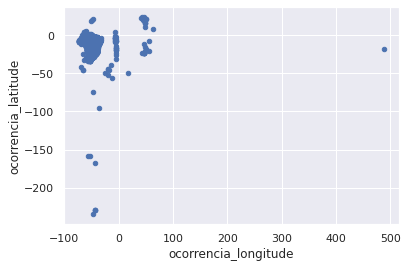

In [49]:
df_prep.plot.scatter(x='ocorrencia_longitude', y='ocorrencia_latitude')

In [50]:
### Temos outliers bem óbvios que devem ser corrigidos. Vamos substituí-los pelas coordendas das suas respectivas cidades
### A cidade mais ao leste do Brasil é João Pessoa
joaopessoa = geolocator.geocode("João Pessoa")
e_lim = joaopessoa.longitude

In [51]:
### Ao norte é Uiramutã

uiramuta = geolocator.geocode('Uiramuta')
n_lim = uiramuta.latitude

In [52]:
### Mais ao sul é Chuí

chui = geolocator.geocode('Chuí')
s_lim = chui.latitude

In [53]:
### e mais ao oeste é Mâncio Lima
mancio_lima = geolocator.geocode('Mâncio Lima')
w_lim = mancio_lima.longitude

In [ ]:
### Vamos substituir as coordendas que estão fora do território nacional, mas não estão no mar

In [ ]:
df_prep.loc[(df_prep['ocorrencia_latitude'] > n_lim) | (df_prep['ocorrencia_latitude'] < s_lim), 'ocorrencia_latitude'] = \
df_cities.loc[df_prep.loc[(df_prep['ocorrencia_latitude'] > n_lim) | (df_prep['ocorrencia_latitude'] < s_lim), 'ocorrencia_cidade'], 'latitude'].tolist()

In [55]:
df_prep.loc[(df_prep['ocorrencia_longitude'] > e_lim) | (df_prep['ocorrencia_longitude'] < w_lim), 'ocorrencia_longitude'] = \
df_cities.loc[df_prep.loc[(df_prep['ocorrencia_longitude'] > e_lim) | (df_prep['ocorrencia_longitude'] < w_lim), 'ocorrencia_cidade'], 'longitude'].tolist()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='ocorrencia_longitude', ylabel='ocorrencia_latitude'>

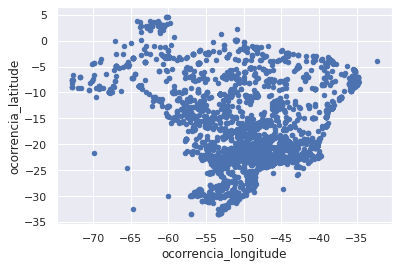

In [56]:
df_prep.plot.scatter(x='ocorrencia_longitude', y='ocorrencia_latitude')

In [57]:
### Tudo ok, vamos checar os outliers fora do território nacional (vamos assumir que os que estão no oceano estão corretos)

df_prep.query('ocorrencia_latitude < -20 & ocorrencia_longitude <-58')

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
1100,80286,80286,80286,80286,80286,ACIDENTE,-30.002500,-60.093889,MANAUS,AM,...,05/09/2021,14:00:00,SIM,FINALIZADA,A-103/CENIPA/2021,SIM,2023-04-17,0,1,NÃO
3145,66974,66974,66974,66974,66974,INCIDENTE,-32.402500,-64.725278,TEFÉ,AM,...,09/07/2017,13:45:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
4150,53149,53149,53149,53149,53149,ACIDENTE,-21.737377,-69.919444,TABATINGA,AM,...,11/03/2015,23:25:00,SIM,FINALIZADA,A-036/CENIPA/2015,SIM,2016-10-14,0,1,NÃO
5177,48727,48727,48727,48727,48727,ACIDENTE,-24.503333,-65.526944,TEFÉ,AM,...,14/06/2013,12:10:00,SIM,FINALIZADA,A-113/CENIPA/2013,SIM,2016-06-03,2,1,NÃO


In [58]:
df_prep.query('ocorrencia_latitude < -32 & ocorrencia_longitude <-55')

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
3145,66974,66974,66974,66974,66974,INCIDENTE,-32.402500,-64.725278,TEFÉ,AM,...,09/07/2017,13:45:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
3512,65589,65589,65589,65589,65589,INCIDENTE,-33.436389,-56.944167,SÃO PAULO,SP,...,01/09/2016,13:26:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
3522,65530,65530,65530,65530,65530,INCIDENTE,-33.436389,-56.944167,SÃO PAULO,SP,...,15/08/2016,18:35:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO


In [59]:
df_prep.loc[(df_prep['ocorrencia_latitude'] < -20) & (df_prep['ocorrencia_longitude'] < -58), 'ocorrencia_latitude'] =\
df_cities.loc[df_prep.query('ocorrencia_latitude < -20 & ocorrencia_longitude <-58')['ocorrencia_cidade'], 'latitude'].tolist()

In [60]:
df_prep.loc[(df_prep['ocorrencia_latitude'] < -20) & (df_prep['ocorrencia_longitude'] < -58), 'ocorrencia_longitude'] =\
df_cities.loc[df_prep.query('ocorrencia_latitude < -20 & ocorrencia_longitude <-58')['ocorrencia_cidade'], 'longitude'].tolist()

In [61]:
df_prep.loc[(df_prep['ocorrencia_latitude'] < -32) & (df_prep['ocorrencia_longitude'] < -55), 'ocorrencia_latitude'] =\
df_cities.loc[df_prep.query('ocorrencia_latitude < -32 & ocorrencia_longitude <-55')['ocorrencia_cidade'], 'latitude'].tolist()

In [62]:
df_prep.loc[(df_prep['ocorrencia_latitude'] < -32) & (df_prep['ocorrencia_longitude'] < -55), 'ocorrencia_longitude'] =\
df_cities.loc[df_prep.query('ocorrencia_latitude < -32 & ocorrencia_longitude <-55')['ocorrencia_cidade'], 'longitude'].tolist()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='ocorrencia_longitude', ylabel='ocorrencia_latitude'>

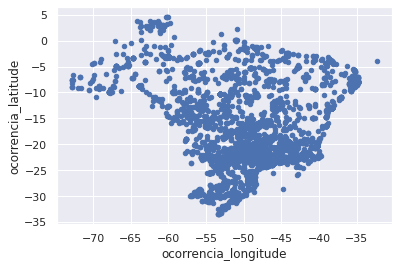

In [63]:
df_prep.plot.scatter(x='ocorrencia_longitude', y='ocorrencia_latitude')

In [ ]:
# Tudo certo! Vamos salvar nossa tabela limpa

df_prep.to_csv('ocorrencia_clean.csv')